In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
appName = "Big Data Analytics"
master = "local[*]"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
 .set('spark.driver.host','127.0.0.1')\
   .setAppName(appName)\
    .setMaster(master)

spark = SparkSession.builder.config(conf = conf).getOrCreate()

In [3]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="systems"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']="fifa.fifa"
db_properties['driver']="org.postgresql.Driver"

In [4]:
def read_from_spark(spark, db_properties):
    df_from_postgres = spark.read \
        .format("jdbc") \
        .option("url", db_properties['url'])\
        .option("dbtable", db_properties['table'])\
        .option("user", db_properties['username'])\
        .option("password", db_properties['password'])\
        .option("Driver", db_properties['driver'])\
        .load()
    df = df_from_postgres.filter(df_from_postgres["gender"] == "Male")
    return df

In [51]:
df_read = read_from_spark(spark, db_properties)

In [52]:
df_read.show()

+-----------+---------+--------------------+---------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+--------------------+--------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+-----------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------

In [73]:
#Setup column categories
col_names = ['record_id',
 'sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'goalkeeping_speed',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm',
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm',
 'rwb',
 'lb',
 'lcb',
 'cb',
 'rcb',
 'rb',
 'gk',
 'player_face_url',
 'club_logo_url',
 'club_flag_url',
 'nation_logo_url',
 'nation_flag_url',
 'year',
 'gender']

ordinal_cols = ['work_rate']
nominal_cols = ['body_type']
continuous_cols = ['potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id',
                   'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'attacking_crossing',
                   'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
                   'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'movement_acceleration',
                   'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                   'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                   'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
                   'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']

conditional_cols = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']

skills_cols = ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control']

position_cols = ['player_positions', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
                   'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

columns_to_drop = ['record_id', 'sofifa_id', 'player_url', 'short_name', 'long_name',
                   'dob', 'club_name', 'league_name', 'club_position', 'club_jersey_number', 'club_loaned_from',
                   'club_joined','club_contract_valid_until', 'nationality_id', 'nationality_name', 'nation_team_id',
                   'nation_position', 'nation_jersey_number', 'preferred_foot', 'real_face', 'player_tags', 'player_traits', 
                   'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url',
                   'year', 'gender']

null_cols_drop = ['release_clause_eur']

corr_cols_drop = ['movement_acceleration']

dropped_null_rows = ['value_eur', 'wage_eur', 'goalkeeping_speed']

impute_cols = ['mentality_composure']

In [74]:
df = df_read.select(continuous_cols + ["overall"]).na.drop(how="any") #drop null rows from colus listed in dropped_null_rows

In [75]:
df.count()

139789

## Outliers

In [76]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df, continuous_cols):
    # Identifying the numerical columns in a spark dataframe

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in continuous_cols:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [77]:
# assuming 'df' is your DataFrame and 'column1', 'column2' are the columns you want to cast as double
for column in continuous_cols:
    df = df.withColumn(column, col(column).cast("double"))

df_outliers = find_outliers(df, continuous_cols)

In [78]:
outlier = df_outliers.groupby("total_outliers").count().sort(col("total_outliers").asc()).show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             0|60227|
|             1|43451|
|             2|12779|
|             3| 8991|
|             4| 6092|
|             5| 3005|
|             6| 1901|
|             7| 1336|
|             8| 1051|
|             9|  591|
|            10|  259|
|            11|   94|
|            12|   11|
|            13|    1|
+--------------+-----+



In [79]:
df_no_outliers = df_outliers.filter(df_outliers['total_Outliers']<=6) #Drop all rows with more than 6 outliers
print(df_no_outliers.count())

136446


In [80]:
df = df_no_outliers

## Correlations

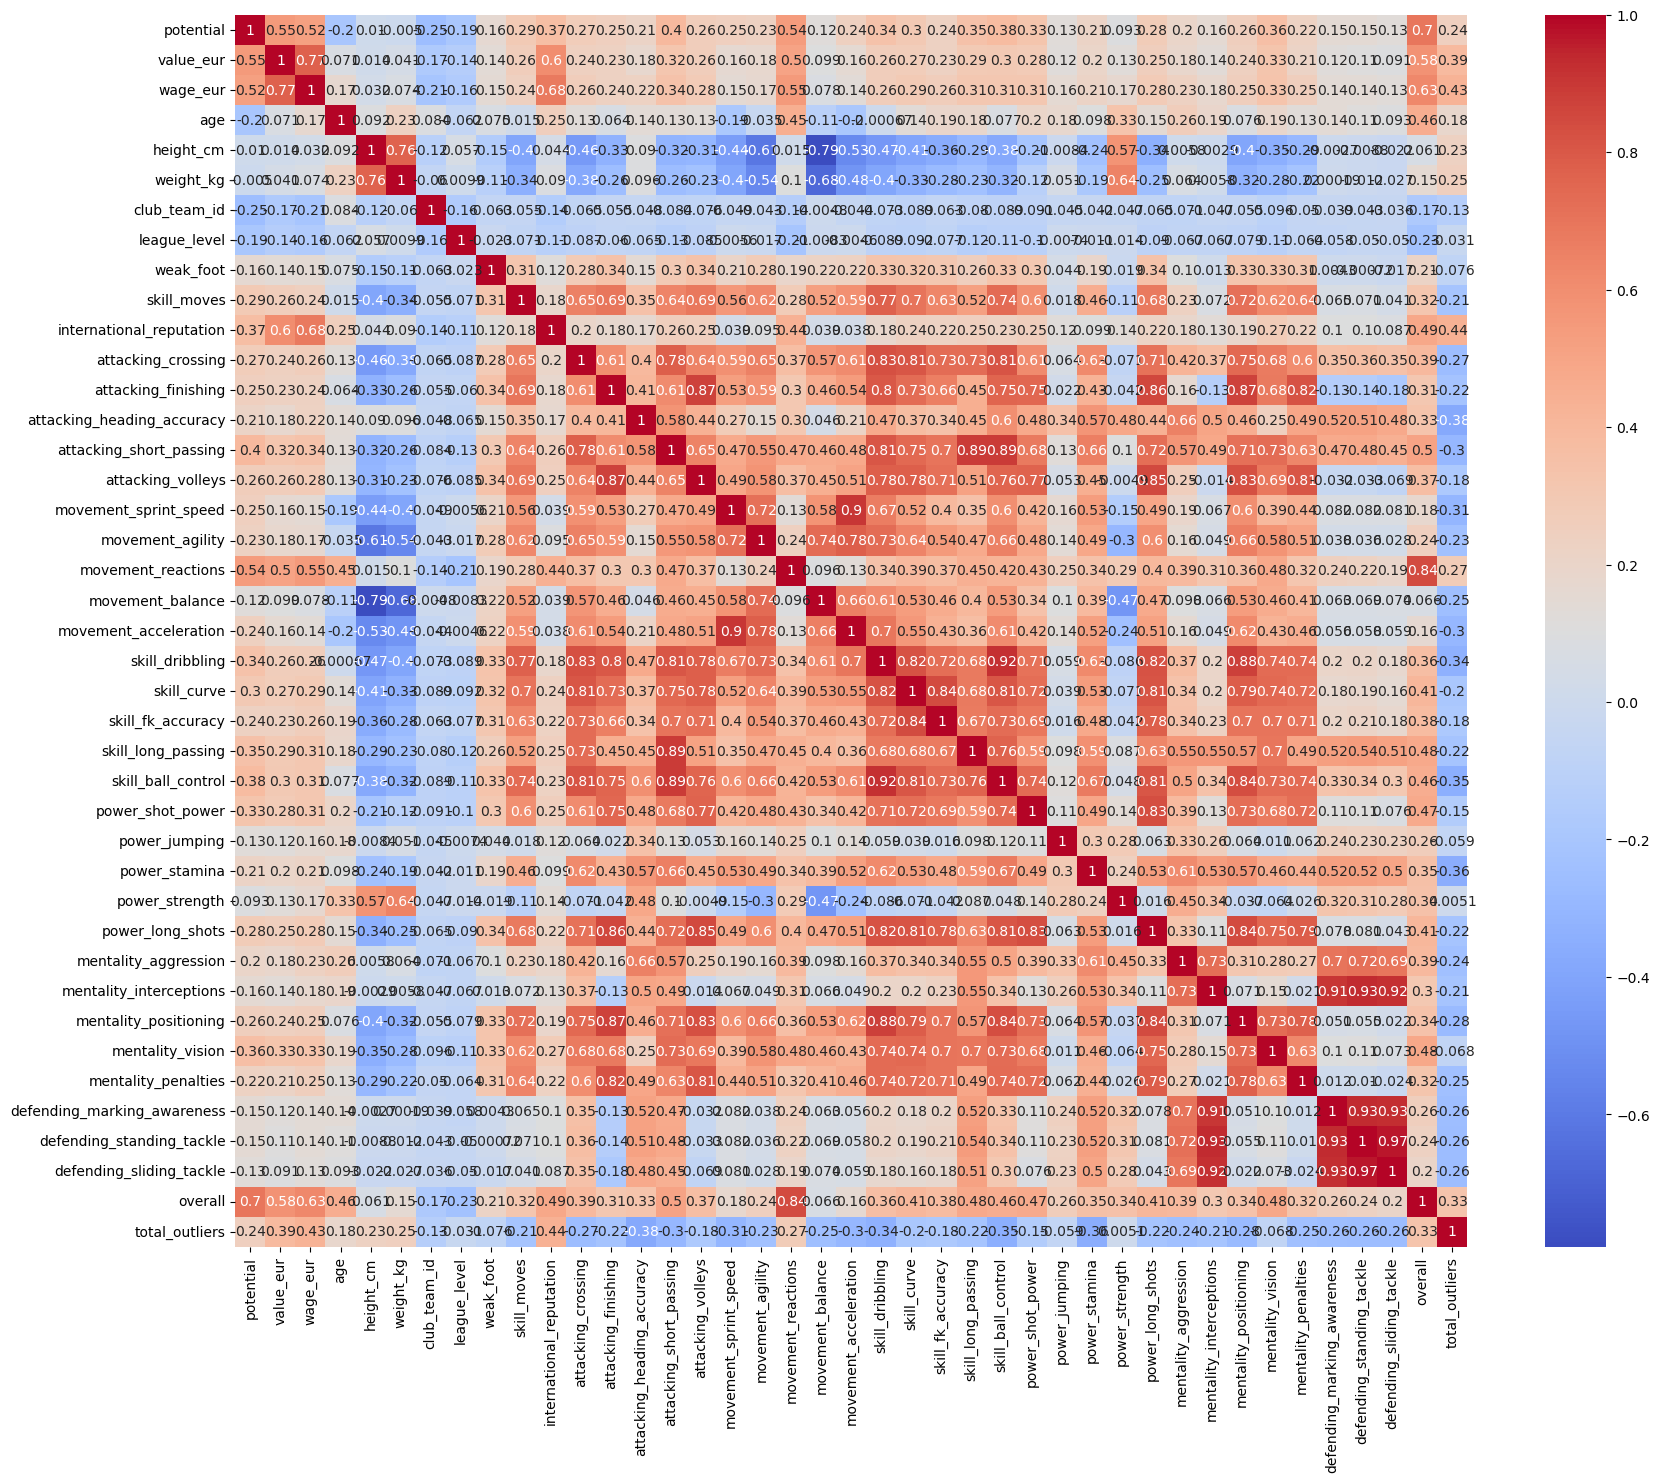

In [81]:
compare_df = df.toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(20, 16))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

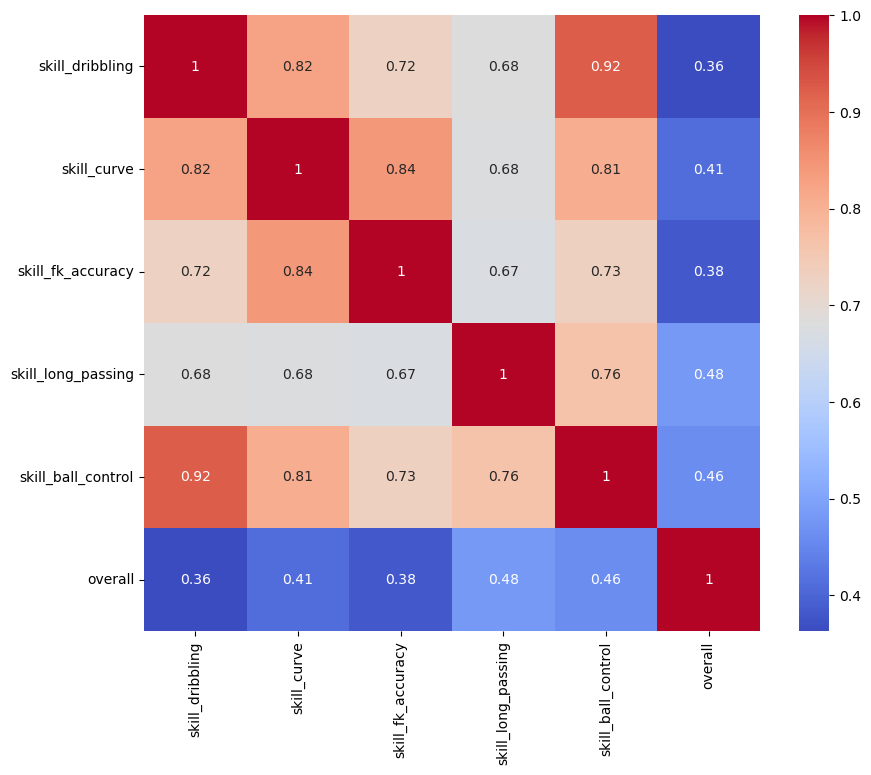

In [82]:
compare_df = df.select('skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'overall').toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

As correlation between skill features is high, create new column with average of all skill features.

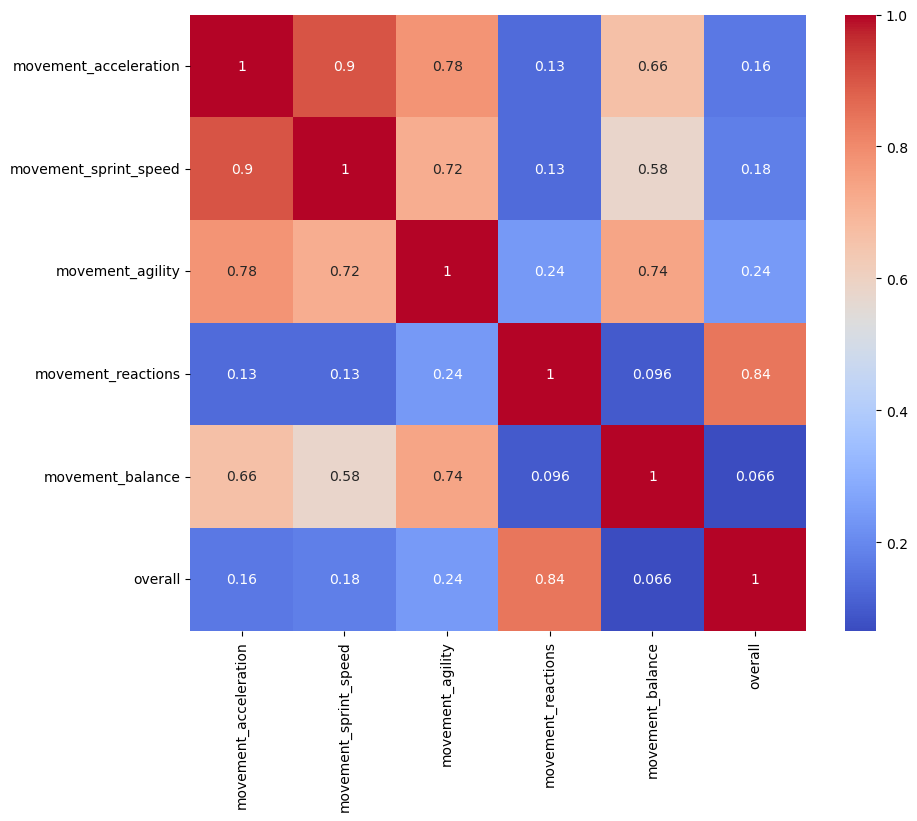

In [83]:
compare_df = df.select('movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'overall').toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

Drop movement_accelration as correlation is 0.92 with movement_sprint_speed.

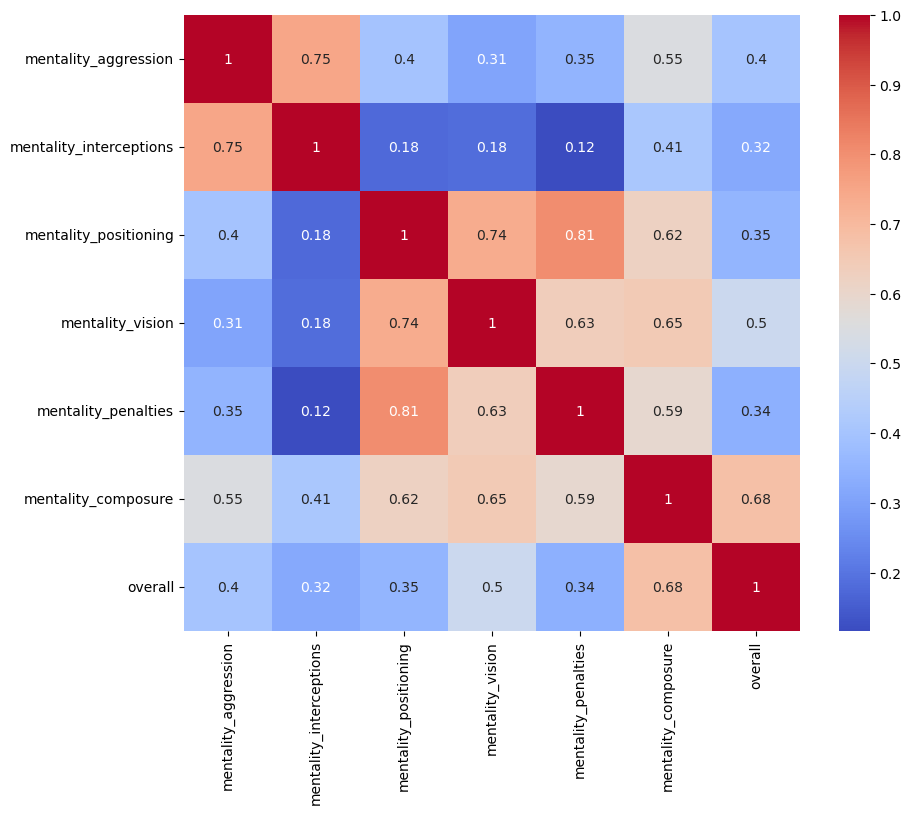

In [84]:
compare_df = df_read.select('mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'overall').toPandas()
compare_df = compare_df.dropna().astype(float)
correlation_matrix = compare_df.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

mentality_composure has many null values. Because there is a decent correlation between mentality_composure and other mentality features, we will use machine learning to impute mentality_composure column using the values in the other mentatlity features. 